### Universidade do Vale do Itajaí - UNIVALI

#### Processamento de Imagens - Professor Felipe Viel

**Alunos**: Daniel Sansão Araldi, Rafael Mota Alves, Kauan Guerreiro Adami Chaves

Instalando **MedMNIST**

In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.1 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

Importantando MedMNIST, Numpy, tqdm e torch.

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

Trabalhando com imagens de tamanho 128x128.

In [ ]:
data_flag = 'pathmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

Lendo os dados do MedMNIST, preprocessando eles e encapsulando eles dentro de um `DataLoader`.

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=128)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [109]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [110]:
def remove_files_in_folder():
  files = glob.glob('./sample_data/tmp/*.jpg')
  for f in files:
      os.remove(f)

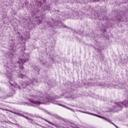

In [111]:
remove_files_in_folder()

train_dataset.montage(length=1, save_folder="./sample_data/tmp/")

image = cv2.imread('./sample_data/tmp/pathmnist_128_train_montage.jpg')
cv2_imshow(image)

Imagens do trabalho.

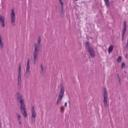

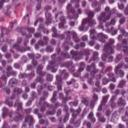

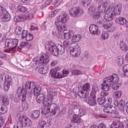

In [112]:
image_skin1 = cv2.imread('./sample_data/images/skin-1.png')
image_skin2 = cv2.imread('./sample_data/images/skin-2.png')
image_skin3 = cv2.imread('./sample_data/images/skin-3.png')

cv2_imshow(image_skin1)
cv2_imshow(image_skin2)
cv2_imshow(image_skin3)

O MSE é uma técnica utilizada para identificar distorções espaciais (estruturas - simetria) da imagem após processamento. Quanto mais próximo do zero, mais iguais as imagens são.


In [113]:
def mse(imageA, imageB):
  err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
  err /= float(imageA.shape[0] * imageA.shape[1])

  return err

O RMSE é o MSE com a aplicação de uma raiz quadrada. Indica o erro padronizado e é geralmente geralmente mais utilizado que o MSE - quanto maior pior.

In [114]:
def rmse(imageA, imageB):
  return np.sqrt(mse(imageA, imageB))

PSNR é a razão entre a potência máxima de um sinal e a potência máxima do sinal do ruído.

1. Medido em dB.
2. Quanto maior melhor (considerável bom >= `20` dB).
3. L indica o valor máximo do pixel (ex: `255`).

In [115]:
def psnr(original, compressed):
  mse = np.mean((original - compressed) ** 2)
  if mse == 0:
    return 100

  max_pixels = 255
  return 20 * np.log10(max_pixels / np.sqrt(mse))

O SSIM é uma métrica baseada em recurso do Sistema Visual Humano (HVS) – Hue, Saturation or Intensity Value.

– O SSIM mede a semelhança entre duas imagens, sendo uma melhoria em relação a métodos como MSE e PSNR.

- Basicamente, calcula a degradação da imagem para algum processo.

– Vai de `-1` a `1`, sendo `1` para imagens idênticas.

In [116]:
!pip install SSIM-PIL

In [117]:
from SSIM_PIL import compare_ssim
from PIL import Image

In [118]:
def ssim(imageA, imageB):
  imageAArray = Image.fromarray(imageA)
  imageBArray = Image.fromarray(imageB)

  return compare_ssim(imageAArray, imageBArray)

O GMSD, assim como SSIM, é uma métrica para o HSV.

- Avalia a distorção causada pelo processamento entre a imagem de referência e a imagem processada.
- Os m’s referem-se as imagens e `c` é uma constante > `0`.
- Quanto maior o valor melhor a qualidade.

In [ ]:
!pip install sporco

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 67.3 MB/s eta 0:00:00


In [119]:
import sporco.metric as sm

In [120]:
def gmsd(original, processed):
  return sm.gmsd(original, processed)

Filtro que permite deixar a imagem com cinza ponderado.

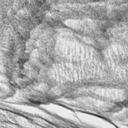

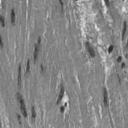

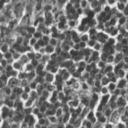

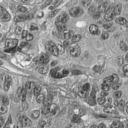

In [121]:
def grayscale_pondered(image):
  B, G, R = cv2.split(image)
  img_grayscale_pondered = 0.299 * B + 0.587 * G + 0.114 * R

  return np.array(img_grayscale_pondered, dtype=np.uint8)

image_grayscale_pondered = grayscale_pondered(image)
image_skin1_pondered = grayscale_pondered(image_skin1)
image_skin2_pondered = grayscale_pondered(image_skin2)
image_skin3_pondered = grayscale_pondered(image_skin3)

cv2_imshow(image_grayscale_pondered)
cv2_imshow(image_skin1_pondered)
cv2_imshow(image_skin2_pondered)
cv2_imshow(image_skin3_pondered)

Filtro que permite deixar a imagem com cinza básico (soma das cores divido por três).

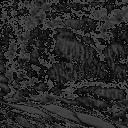

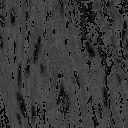

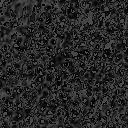

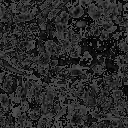

In [122]:
def grayscale_basic(image):
  B, G, R = cv2.split(image)
  img_grayscale_basic = (B+G+R)/3

  return np.array(img_grayscale_basic, dtype=np.uint8)

image_grayscale_basic = grayscale_basic(image)
image_skin1_basic = grayscale_basic(image_skin1)
image_skin2_basic = grayscale_basic(image_skin2)
image_skin3_basic = grayscale_basic(image_skin3)

cv2_imshow(image_grayscale_basic)
cv2_imshow(image_skin1_basic)
cv2_imshow(image_skin2_basic)
cv2_imshow(image_skin3_basic)

Adiciona `padding` a imagem.

In [123]:
def add_padding(img, padding_height, padding_width):
    n, m = img.shape

    padded_img = np.zeros((n + padding_height * 2, m + padding_width * 2))
    padded_img[padding_height : n + padding_height, padding_width : m + padding_width] = img

    return padded_img

Realiza a convolação da imagem.

In [124]:
def conv2d(img, kernel, padding=True):
    # Get dimensions of the kernel
    k_height, k_width = kernel.shape

    # Get dimensions of the image
    img_height, img_width = img.shape

    # Calculate padding required
    pad_height = k_height // 2
    pad_width = k_width // 2

    # Create a padded version of the image to handle edges
    if padding == True:
        padded_img = add_padding(img, pad_height, pad_width)

    # Initialize an output image with zeros
    output = np.zeros((img_height, img_width), dtype=float)

    # Perform convolution
    for i_img in range(img_height):
        for j_img in range(img_width):
            for i_kernel in range(k_height):
                for j_kernel in range(k_width):
                    output[i_img, j_img] = output[i_img, j_img] + (padded_img[i_img+i_kernel, j_img+j_kernel] * kernel[i_kernel, j_kernel])
            output[i_img, j_img] = int(output[i_img, j_img])

    return np.clip(output, 0, 255).astype(np.uint8)

Filtro Laplaciano

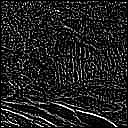

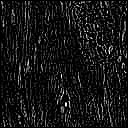

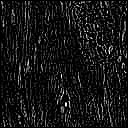

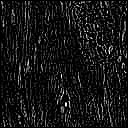

In [125]:
laplacian_kernel = np.array([[1, 1, 1],
                             [1, -8, 1],
                             [1, 1, 1]])

def laplacian(image, kernel):
    return conv2d(image, kernel)

image_laplacian = laplacian(image_grayscale_pondered, laplacian_kernel)
image_skin1_laplacian = laplacian(image_skin1_pondered, laplacian_kernel)
image_skin2_laplacian = laplacian(image_skin2_pondered, laplacian_kernel)
image_skin3_laplacian = laplacian(image_skin3_pondered, laplacian_kernel)

cv2_imshow(image_laplacian)
cv2_imshow(image_skin1_laplacian)
cv2_imshow(image_skin1_laplacian)
cv2_imshow(image_skin1_laplacian)

Filtro de Gaussiano

In [126]:
def gaussian_kernel(size, sigma=1):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)

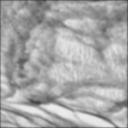

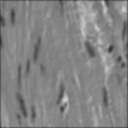

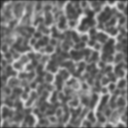

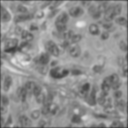

In [127]:
def gaussian(img, kernel):
    height, width = img.shape
    k_size = kernel.shape[0]
    pad = k_size // 2

    padded_img = add_padding(img, pad, pad)
    smoothed_img = np.zeros_like(img, dtype=float)

    for i in range(height):
        for j in range(width):
            region = padded_img[i:i+k_size, j:j+k_size]
            smoothed_img[i, j] = np.sum(region * kernel)

    return np.clip(smoothed_img, 0, 255).astype(np.uint8)

kernel = gaussian_kernel(size=5)
image_gaussian = gaussian(image_grayscale_pondered, kernel)
image_skin1_gaussian = gaussian(image_skin1_pondered, kernel)
image_skin2_gaussian = gaussian(image_skin2_pondered, kernel)
image_skin3_gaussian = gaussian(image_skin3_pondered, kernel)
cv2_imshow(image_gaussian)
cv2_imshow(image_skin1_gaussian)
cv2_imshow(image_skin2_gaussian)
cv2_imshow(image_skin3_gaussian)

Filtro de Mediana

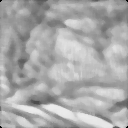

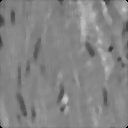

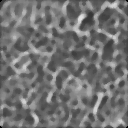

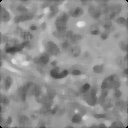

In [128]:
def median(image, kernel_size=5):
    pad_size = kernel_size // 2

    if len(image.shape) == 3:
        channels = cv2.split(image)
        filtered_channels = []
        for ch in channels:
            padded_ch = add_padding(ch, pad_size, pad_size)
            n, m = ch.shape
            output_ch = np.zeros_like(ch)
            for i in range(n):
                for j in range(m):
                    window = padded_ch[i:i+kernel_size, j:j+kernel_size]
                    output_ch[i, j] = np.median(window)
            filtered_channels.append(output_ch)
        output = cv2.merge(filtered_channels)
    else:
        padded_img = add_padding(image, pad_size, pad_size)
        n, m = image.shape
        output = np.zeros_like(image)
        for i in range(n):
            for j in range(m):
                window = padded_img[i:i+kernel_size, j:j+kernel_size]
                output[i, j] = np.median(window)
    return output

image_median = median(image_grayscale_pondered)
image_skin1_median = median(image_skin1_pondered)
image_skin2_median = median(image_skin2_pondered)
image_skin3_median = median(image_skin3_pondered)

cv2_imshow(image_median)
cv2_imshow(image_skin1_median)
cv2_imshow(image_skin2_median)
cv2_imshow(image_skin3_median)

Filtro High-Boost Filtering

High Boost with Gaussian:


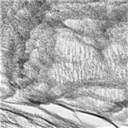

High Boost with Median:


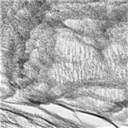

High Boost with Gaussian:


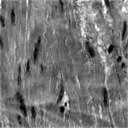

High Boost with Median:


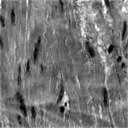

High Boost with Gaussian:


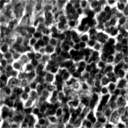

High Boost with Median:


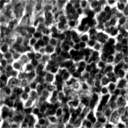

High Boost with Gaussian:


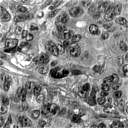

High Boost with Median:


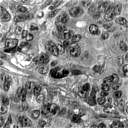

In [129]:
def high_boost(image, image_blurred):
    C = 1.5
    alpha = C
    beta = -(C - 1)
    gamma = 0

    result = alpha * image + beta * image_blurred + gamma

    return np.clip(result, 0, 255).astype(np.uint8)

image_high_boost_with_gaussian = high_boost(image_grayscale_pondered, image_gaussian)
print("High Boost with Gaussian:")
cv2_imshow(image_high_boost_with_gaussian)
image_high_boost_with_median = high_boost(image_grayscale_pondered, image_gaussian)
print("High Boost with Median:")
cv2_imshow(image_high_boost_with_median)

image_high_boost_with_gaussian = high_boost(image_skin1_pondered, image_gaussian)
print("High Boost with Gaussian:")
cv2_imshow(image_high_boost_with_gaussian)
image_high_boost_with_median = high_boost(image_skin1_pondered, image_gaussian)
print("High Boost with Median:")
cv2_imshow(image_high_boost_with_median)

image_high_boost_with_gaussian = high_boost(image_skin2_pondered, image_gaussian)
print("High Boost with Gaussian:")
cv2_imshow(image_high_boost_with_gaussian)
image_high_boost_with_median = high_boost(image_skin2_pondered, image_gaussian)
print("High Boost with Median:")
cv2_imshow(image_high_boost_with_median)

image_high_boost_with_gaussian = high_boost(image_skin3_pondered, image_gaussian)
print("High Boost with Gaussian:")
cv2_imshow(image_high_boost_with_gaussian)
image_high_boost_with_median = high_boost(image_skin3_pondered, image_gaussian)
print("High Boost with Median:")
cv2_imshow(image_high_boost_with_median)

Filtro de Sobel

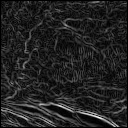

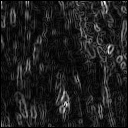

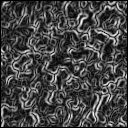

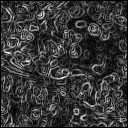

In [130]:
def normalize(img):
    img = np.abs(img)
    img = (img / img.max()) * 255
    return img.astype(np.uint8)

def sobel(image):
  # Convert to float64
  image = image.astype(np.float64)

  # Define Sobel kernels
  kernel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
  ])

  kernel_y = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
  ])

  # Initialize output arrays
  height, width = image.shape
  sobel_x = np.zeros_like(image)
  sobel_y = np.zeros_like(image)

  # Apply convolution manually (ignoring borders)
  for i in range(1, height - 1):
      for j in range(1, width - 1):
          region = image[i - 1:i + 2, j - 1:j + 2]
          gx = np.sum(kernel_x * region)
          gy = np.sum(kernel_y * region)
          sobel_x[i, j] = gx
          sobel_y[i, j] = gy

  # Compute combined gradient magnitude
  sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)

  # Normalize all outputs to range [0, 255] and convert to uint8
  return normalize(sobel_combined)

image_sobel = sobel(image_grayscale_pondered)
image_skin1_sobel = sobel(image_skin1_pondered)
image_skin2_sobel = sobel(image_skin2_pondered)
image_skin3_sobel = sobel(image_skin3_pondered)

cv2_imshow(image_sobel)
cv2_imshow(image_skin1_sobel)
cv2_imshow(image_skin2_sobel)
cv2_imshow(image_skin3_sobel)

Correça Gama

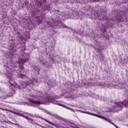

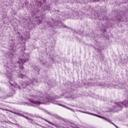

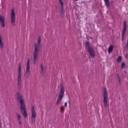

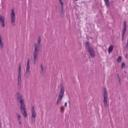

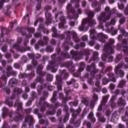

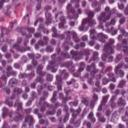

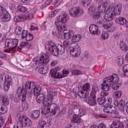

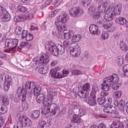

In [131]:
def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

image_gamma = adjust_gamma(image, 0.75)
cv2_imshow(image_gamma)
cv2_imshow(image)

image_skin1_gamma = adjust_gamma(image_skin1, 0.75)
cv2_imshow(image_skin1_gamma)
cv2_imshow(image_skin1)

image_skin2_gamma = adjust_gamma(image_skin2, 0.75)
cv2_imshow(image_skin2_gamma)
cv2_imshow(image_skin2)

image_skin3_gamma = adjust_gamma(image_skin3, 0.75)
cv2_imshow(image_skin3_gamma)
cv2_imshow(image_skin3)

Equalização de Hitograma

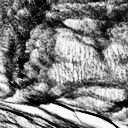

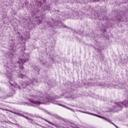

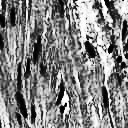

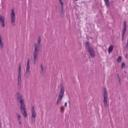

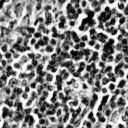

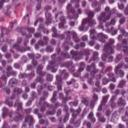

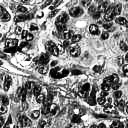

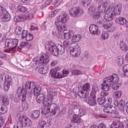

In [132]:
def histogram_equalization(image):
    height, width = image.shape

    histogram = np.zeros(256, dtype=int)
    for i in range(height):
        for j in range(width):
            intensity = image[i, j]
            histogram[intensity] += 1

    cdf = np.zeros(256, dtype=int)
    cumulative = 0
    for i in range(256):
        cumulative += histogram[i]
        cdf[i] = cumulative

    cdf_min = cdf[np.nonzero(cdf)].min()
    total_pixels = height * width
    cdf_normalized = np.round((cdf - cdf_min) / (total_pixels - cdf_min) * 255).astype('uint8')

    equalized_image = np.zeros_like(image)
    for i in range(height):
        for j in range(width):
            pixel_value = image[i, j]
            equalized_image[i, j] = cdf_normalized[pixel_value]

    return equalized_image

image_equalizated = histogram_equalization(image_grayscale_pondered)
cv2_imshow(image_equalizated)
cv2_imshow(image)

image_skin1_equalizated = histogram_equalization(image_skin1_pondered)
cv2_imshow(image_skin1_equalizated)
cv2_imshow(image_skin1)

image_skin2_equalizated = histogram_equalization(image_skin2_pondered)
cv2_imshow(image_skin2_equalizated)
cv2_imshow(image_skin2)

image_skin3_equalizated = histogram_equalization(image_skin3_pondered)
cv2_imshow(image_skin3_equalizated)
cv2_imshow(image_skin3)

Aplicando ruído de sal e pimenta

In [162]:
def salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    noisy = image.copy()
    rnd = np.random.rand(*image.shape[:2])

    if len(image.shape) == 2:
        noisy[rnd < salt_prob] = 255
        noisy[rnd > 1 - pepper_prob] = 0
    else:
        for c in range(image.shape[2]):
            channel = noisy[:, :, c]
            channel[rnd < salt_prob] = 255
            channel[rnd > 1 - pepper_prob] = 0
            noisy[:, :, c] = channel

    return noisy

#### Fluxo do Processamento

1. **Preparação das imagens**: o Escolher duas ou três imagens do dataset indicado e preparar elas para processar. Como forma de avaliar a efetividade dos filtros, é interessante aplicar ruído como sal e pimenta e comparar a imagem original (antes de aplicar o ruído) e posterior a aplicação de filtros (na imagem com ruído).

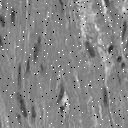

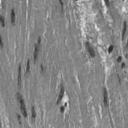

In [207]:
image_skin1_salt_and_papper = salt_and_pepper_noise(image_skin1_pondered)
cv2_imshow(image_skin1_salt_and_papper)
cv2_imshow(image_skin1_pondered)

2. **Pré-processamento**: o Aplicar **equalização de histograma** e **correção gama** para melhorar o contraste.

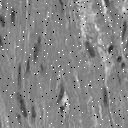

In [208]:
image_skin1_gamma = adjust_gamma(image_skin1_salt_and_papper)
cv2_imshow(image_skin1_gamma)

3. **Redução de ruído**: o Aplicar um **filtro Gaussiano** ou **mediana** para suavizar a imagem sem perder muitos detalhes.

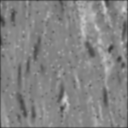

In [209]:
kernel = gaussian_kernel(size=5)
image_skin1_gaussian = gaussian(image_skin1_gamma, kernel)
cv2_imshow(image_skin1_gaussian)

4. **Realce de bordas**: o Aplicar um **filtro Laplaciano** ou **operador de Sobel** para destacar contornos importantes.

**Observação**: O Realce de bordas foi descartado do fluxo de processamento, as métricas de qualidade das imagens são piores quanto o realce de borda é aplicado.

In [212]:
# image_skin1_laplacian = laplacian(image_skin1_gaussian, laplacian_kernel)
# cv2_imshow(image_skin1_laplacian)

5. **Ajuste final (High-Boost Filtering)**: o Reforçar detalhes combinando a imagem original com a filtrada para um realce
equilibrado.

Image processed grayscale:


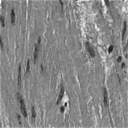

Origial image grayscale:


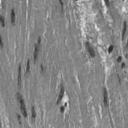

In [213]:
image_skin1_high_boost = high_boost(image_skin1_pondered, image_skin1_gaussian)
print("Processed processed grayscale:")
cv2_imshow(image_skin1_high_boost)
print("Origial image grayscale:")
cv2_imshow(image_skin1_pondered)


#### Métricas de Qualidade

1. MSE - Quanto mais próximo do zero, mais iguais as imagens são.

In [211]:
equal = mse(image_skin1_pondered, image_skin1_high_boost)
print(equal)

33.21112060546875


2. RMSE - Igual ao MSE, mas quanto maior pior.

In [203]:
equal = rmse(image_skin1_pondered, image_skin1_high_boost)
print(equal)

50.801150547725356


3. PSNR - É a razão entre a potência máxima de um sinal e a potência máxima do sinal do ruído. Quanto maior melhor (considerável bom >= `20` dB).

(Boa para avaliar filtros de suavização)

In [204]:
db = psnr(image_skin1_pondered, image_skin1_high_boost)
print(db)

27.665704784815162


4. SSIM - É uma métrica baseada em recurso do Sistema Visual Humano (HVS) – Hue, Saturation or Intensity Value.

- O SSIM mede a semelhança entre duas imagens, sendo uma melhoria em relação a métodos como MSE e PSNR.
- Basicamente, calcula a degradação da imagem para algum processo.
- Vai de `-1` a `1`, sendo `1` para imagens idênticas.

In [205]:
egual = ssim(image_skin1_pondered, image_skin1_high_boost)
print(egual)

No module named 'pyopencl'
0.7771812188511001


5. GMSD - Assim como SSIM, é uma métrica para o HSV.

- Avalia a distorção causada pelo processamento entre a imagem de referência e a imagem processada.
- Quanto maior o valor melhor a qualidade.

In [206]:
egual = gmsd(image_skin1_pondered, image_skin1_high_boost)
print(egual)

0.14920599101633214
